##Image matching

We saw in the first notebook "Seeing the light" that all regions oscillate with a period close to 24 hours. A more complicated question is to determine how individual neurons oscillate. AS the neurons move slightly between time frames, I had the idea to track them over time. Contents here are:

1. Image processing and affine transforms

2. Normalizing the data

3. Choosing an affine transform that minimizes image mismatch.

In the end, I do not think this is useful for this particular dataset. In order to apply it we would need far more complex transform than the simple rotations looked at here, and implementing this would be a massive undertaking. Also, in the end, most neurons don't move that much, and there are other inconsistencies in the data that probably affect analysis far more.

I leave the notebook here, as it could be an example how to apply scipy.optimize with a home-built model.

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt # graphs
%matplotlib inline
from scipy.ndimage.filters import uniform_filter, gaussian_filter # to smooth images
from scipy.optimize import minimize # optimization

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

data141110.csv
flo_image_1.npz
flo_image_2.npz
flo_images



## 1. Image processing and affine transforms

Equivalents to these functions can be found in standard libraries, you can safely skip to parts 2 and 3.

In [2]:
def square_indices(bbox):
    """
    Returns a (N,2) array of indices, corresponding to all points 
    in the bbox (x_max, y_min, x_max, y_max)
    """
    x_min, y_min, x_max, y_max = bbox
    grid = np.indices((x_max-x_min, y_max-y_min))
    return np.add(np.hstack((grid[0].reshape(-1, 1), grid[1].reshape(-1, 1))), (x_min, y_min))

In [3]:
def rotation_matrix(theta):
    """
    Arguments:
        theta - a numpy array of any dimension D
    returns a 2x2xD numpy matrix M with the 2x2 matrix such that 'np.tensordot(x,M,1)' corresponds
    to rotation with theta
    """
    return np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

In [4]:
def affine_transform(x, f):
    """
    Returns the effect on x of the affine transformation f = (x0,x1,theta), 
    which moves the origin to (x0, x1) and rotates the plane by the angle theta (in radians)
    Arguments:
        x - a (N,2) 2D integer numpy array, giving coordinates in a plane neighbourhood of size 
             N=height*weight
        f - a (3,M) 2D numpy array, with M corresponding to time frame
    Returns a (N,2,M) numpy float array, with coordinates for each time frame.
    If f is an (3,) 1D numpy array, an (N,2) numpy array is returned
    """
    if f.ndim == 1:
        return f[:2] + np.dot(x, rotation_matrix(f[2]))
    else:
        return f[:2, :] + np.dot(x, rotation_matrix(f[2, :]))

In [5]:
def interpolate(x, im):
    """
    Arguments:
        x - (N,2) numpy float array
        image - (hxw) numpy array
    Returns (N,) array of image values att x subpixel coordinates, bilinear interpolation
    Assumes that the values of x are contained in hxw
    """
    delta, fl = np.modf(x)
    fl = fl.astype("int")
    return (im[fl[:, 0], fl[:, 1]] * (1 - delta[:, 0]) * (1 - delta[:, 1]) +
            im[1 + fl[:, 0], fl[:, 1]] * delta[:, 0] * (1 - delta[:, 1]) +
            im[fl[:, 0], 1 + fl[:, 1]] * (1 - delta[:, 0]) * delta[:, 1] +
            im[1 + fl[:, 0], 1 + fl[:, 1]] * delta[:, 0] * delta[:, 1])

In [6]:
def contained(x, image, square=True):
    """
    Are the coordinates in x contained in image's domain?
    Arguments:
        x - (N,2) numpy array, list of coordinates
        image - (h,w) numpy array
        square - if True, x corresponds to a square
    Note: this works for bilinear interpolation, a more advanced
    interpolation method needs a stricter criterion.
    """
    if square:
        return min(x[0, 0], x[0, 1], x[-1, 0], x[-1, 1]) >= 0 and \
                max(x[0, 0], x[-1, 0]) <= image.shape[0] - 2 and \
                max(x[0, 1], x[-1, 1]) <= image.shape[1] - 2
    else:
        return np.min(x) >= 0 and \
                np.max(x[:, 0]) <= image.shape[0] - 2 and \
                np.max(x[:, 1]) <= image.shape[1] - 2

In [7]:
def image_pullback(bbox, f, im):
    """
        Computes values im(f(x)). Uses bilinear interpolation.
        Arguments:
            bbox - a 4-tuple (x_min, y_min, x_max, y_max) giving the side lengths of the square
            f - an (3,) numpy float array, corresponding to an affine transformation
            im - a 2D numpy array such that f(x) is a subset of the image coordinates
        Returns an NxM 2D numpy array, corresponding to the image values in f(K),
        but interpolated to subpixels.
    """
    x_min, y_min, x_max, y_max = bbox
    y = affine_transform(square_indices(bbox), f)
    if not contained(y, im):
        return None
    return interpolate(y, im).reshape(x_max-x_min, y_max-y_min)

## 2. Normalize the data

In [8]:
flo_image_1 = np.load('../input/flo_image_1.npz')
flo_image_2 = np.load('../input/flo_image_2.npz')
images = np.concatenate([flo_image_1['image_stack'], flo_image_2['image_stack']]).astype("float32")
del flo_image_1, flo_image_2 # Save Kaggle RAM

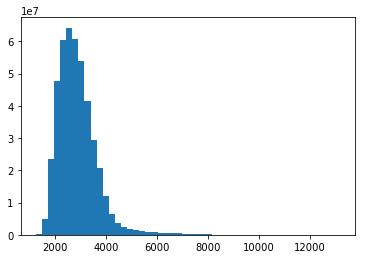

In [9]:
hist = plt.hist(images.flatten(), bins = 50)

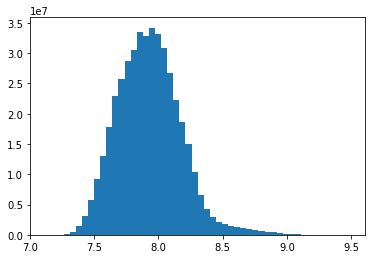

In [10]:
hist = plt.hist(np.log(images.flatten()), bins=50)

These plots suggest that the data follows a log normal distribution. We will however not take the logarithm, but instead subtract away all global data by applying image filters. Also, we will for now ignore the bright vertical line in the middle, as it upsets the mean (see previous kernel). 

In [11]:
def preprocess(images, p1=1., p2=99., std1=1.5, std2=16.):
    """
    First normalizes around zero by subtracting a gaussian filter, then clipping the p1,p2 percentiles.
    The result will have float values between 0 and 1.
    """

    #We want to see neurons in contrast with their surroundings, 
    #and for now we don't care about non-local features.
    images = (gaussian_filter(images, sigma=(0,std1,std1)) -
              gaussian_filter(images, sigma=(0,std2,std2)))

    
    #We run a loop over time - doing clip vectorised crashes the computer for some reason.
    for time in range(images.shape[0]):
        lo = np.percentile(images[time], p1)
        hi = np.percentile(images[time], p2)
        images[time] = (np.clip(images[time], lo, hi) - lo) / (hi - lo)
    return images

In [12]:
left = preprocess(images[:,224:,:224]) # We only look at the lower left quadrant for now.

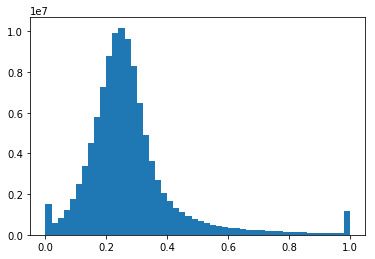

In [13]:
hist = plt.hist(left.flatten(), bins=50)

Let's compare before and after on some interesting areas - selected from the previous kernel.

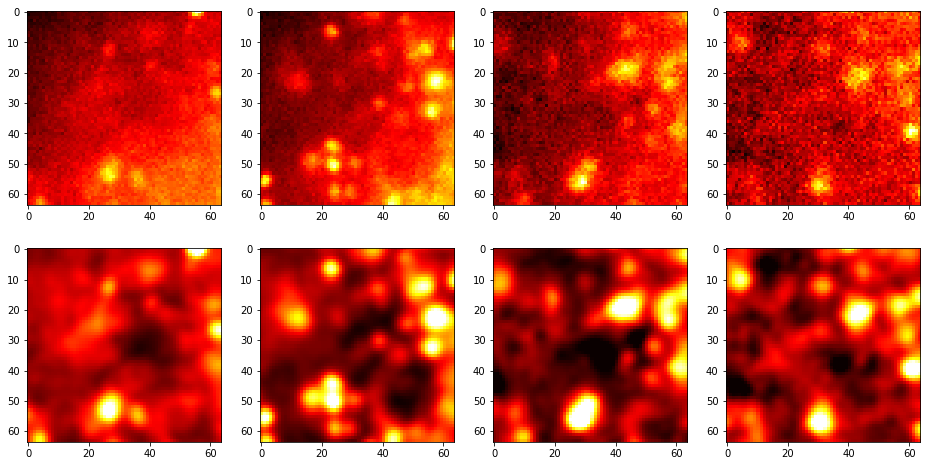

In [14]:
b1,b2,b3,b4 = (32,96,160,224)
fig, ax = plt.subplots(2,4,figsize=(16,8))
ax[0,0].imshow(images[100,224+b1:224+b2:,b3:b4], cmap='hot')
ax[0,1].imshow(images[320,224+b1:224+b2:,b3:b4], cmap='hot')
ax[0,2].imshow(images[1050,224+b1:224+b2:,b3:b4], cmap='hot')
ax[0,3].imshow(images[1650,224+b1:224+b2:,b3:b4], cmap='hot')
ax[1,0].imshow(left[100,b1:b2,b3:b4], cmap='hot', vmin=0., vmax=1.)
ax[1,1].imshow(left[320,b1:b2,b3:b4], cmap='hot', vmin=0., vmax=1.)
ax[1,2].imshow(left[1050,b1:b2,b3:b4], cmap='hot', vmin=0., vmax=1.)
ax[1,3].imshow(left[1650,b1:b2,b3:b4], cmap='hot', vmin=0., vmax=1.)

It seems to work well: some noise is removed but the bright spots corresponding to neurons remain.

## 3. Minimize image mismatch

We will now define a loss function for mismatch between two images, and then minimize this over all orthonormal affine transforms, using scipy.

In [15]:
def mse(arr1, arr2):
    """
        Computes the mean squared error.
        Arguments:
            arr1, arr2 - numpy arrays of identical dimensions
    """   
    return ((arr1-arr2) ** 2).mean(axis=None)

In [16]:
def get_kappa(k1, k2):
    """
    Returns a 3x3 matrix with (k1,k1,k2) along the diagonal,
    to be used as regularization.
    """
    return np.diag([k1,k1,k2])

We create a loss function that measure the error between one image and a transformed version of the next image. The idea is to find the optimal transform so that they match. 

In [17]:
def next_loss(f1, image1, bbox, pullback0, kappa = get_kappa(2e-5, 0.002)):
    """ 
    Arguments: 
        f1 - (3,) numpy array
        image1 - (h,w) float numpy array
        bbox - a 4-tuple
        pullback0 - the image that image_pullback(x,f1,image1) will be compared to 
        kappa - a 3x3 matrix of regularisation weights
    """
    pullback1 = image_pullback(bbox, f1, image1)
    if pullback1 is None:
        return 1e6
    return mse(pullback1, pullback0) + np.dot(np.dot((f0-f1).T, kappa), f0-f1)

##4. Now the fun begins
We now use 'scipy.optimize' to minimize our loss function. To make this more stable we compare the image with an average over a few time frames, added through the momentum.

In [18]:
stop = left.shape[0]
f0 = np.array([0.,0.,0.])
bbox = (64,160,96,192)
best_f = np.tile(f0.reshape(1,3), (stop,1))
score_f = np.zeros((stop,), dtype="float32")
momentum = 0.9
pullback0 = image_pullback(bbox, best_f[0], left[0])

In [19]:
for k in range(1,stop):
    min2 = minimize(next_loss, best_f[k-1], 
                    args=(left[k], bbox, pullback0, get_kappa(2e-5, 2e-3)),
                    method="powell", jac=False, options={'disp':False})
    best_f[k] = min2.x
    score_f[k] = min2.fun
    pullback0 = momentum * pullback0 + (1.-momentum) * image_pullback(bbox, best_f[k], left[k])

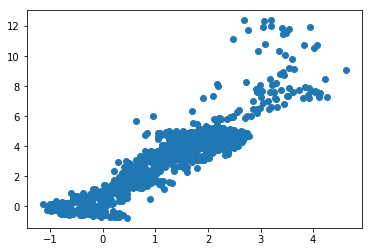

In [20]:
plt.scatter(best_f[:,0], best_f[:,1])

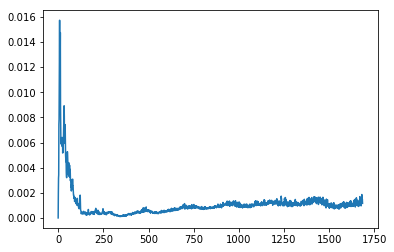

In [21]:
plt.plot(np.arange(stop), score_f)

[ 0.028 -0.515  0.072] [ 0.29   1.063  0.077]


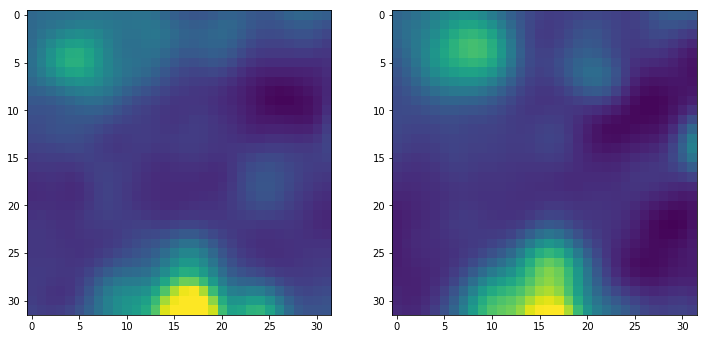

In [22]:
i = 200
j = i + 200
np.set_printoptions(precision=3, suppress=True)
print(best_f[i], best_f[j])
fig,ax = plt.subplots(1,2,figsize=(12,12))
ax[0].imshow(image_pullback(bbox, best_f[i], left[i]), vmin=0, vmax=1)
ax[1].imshow(image_pullback(bbox, best_f[j], left[j]), vmin=0, vmax=1)

This could be a good start for further analysis. We can still tune the hyperparameters k1, k2, momentum. More importantly, we can repeat the procedure for squares of different centers and sizes and see if results are consistent.

I have in fact also computed the gradients for these functions.  I did not include them here, as this does not make optimization faster. I think this is because the gradient of bilinear interpolation is discontinuous, so if we wanted to do this big scale, we should perhaps use Lanczos in at all integers. Also, I realized that this notebook is big enough at it is and will call it a day here.

Hope you've enjoyed it!